In [1]:
require(glmnet)
require(ggplot2)
require(data.table)
require(glmnet)
require(rpart)
require(rattle)
require(skimr)
require(tidyverse)
require(dplyr)
require(caret)
library(maptree)
library(ranger)
library(e1071)
library(gbm)

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: ggplot2

Loading required package: data.table

Loading required package: rpart

Loading required package: rattle

Loading required package: tibble

Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

Loading required package: skimr

Loading required package: tidyverse

── Attaching packages ──────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tidyr   1.1.2     ✔ dplyr   1.0.2
✔ readr   1.4.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.0

── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks Matrix::expand()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::fir

In [2]:
# Reading data
data_1 <- read.csv2("/Users/canhakan/Desktop/IE 582/hw4/Student Performance Data Set /student-por.csv", header = TRUE)
data_2 <-read.csv("/Users/canhakan/Desktop/IE 582/hw4/Breast Cancer Wisconsin (Original)/wdbc.data", header = FALSE)
data_3 <- read.csv("/Users/canhakan/Desktop/IE 582/hw4/OnlineNewsPopularity/OnlineNewsPopularity.csv", header = T)
data_4 <- read.csv("/Users/canhakan/Desktop/IE 582/hw4/Polish companies bankruptcy data/data/4year.csv", header = T)

In [3]:
data_org_1 <- data_1 #Backing up the data.

In [4]:
# Changing the multiclass attribute to different binomial attributes for Penalized Regression Approach
data_1 = data_org_1  %>% 
    mutate(MTeacher = ifelse(Mjob == 'teacher', 1, 0)) %>% 
    mutate(MHealth = ifelse(Mjob == 'health', 1, 0)) %>% 
    mutate(MServices = ifelse(Mjob == 'services', 1, 0)) %>% 
    mutate(MOther = ifelse(Mjob == 'other', 1, 0)) %>% 
    mutate(MAthome = ifelse(Mjob == 'at_home', 1, 0))  %>% 
    mutate(FTeacher = ifelse(Fjob == 'teacher', 1, 0)) %>% 
    mutate(FHealth = ifelse(Fjob == 'health', 1, 0)) %>% 
    mutate(FServices = ifelse(Fjob == 'services', 1, 0)) %>% 
    mutate(FOther = ifelse(Fjob == 'other', 1, 0)) %>% 
    mutate(FAthome = ifelse(Fjob == 'at_home', 1, 0))  %>% 
    # reasonhome reasonreputation reasoncourse reasonother
    mutate(reasonhome = ifelse(reason == 'home',1, 0))  %>% 
    mutate(reasonreputation = ifelse(reason == 'reputation',1, 0))  %>% 
    mutate(reasoncourse = ifelse(reason == 'course',1, 0))  %>% 
    mutate(reasonother = ifelse(reason == 'other',1, 0))  %>% 
    select(-Mjob,-Fjob,-reason) %>% 
    # Also removing G2 and G3 for dataset to be harder. We will predict students 1st exam grades without having another exam data
    select(-G2,-G3)
###
data_org_3 <- data_3
data_3  <- data_org_3  %>% select(-url,-timedelta)
###

In [5]:
# Creating common fit control
fit_control = trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 10) 

In [24]:
# DATA 1 splitting
set.seed(1)
# test-train index
index_1 <- createDataPartition(y = data_1$G1, p = .75, list = FALSE)
# create the split
data_train_1 <- data_1[index_1,]
data_test_1 <- data_1[-index_1,]

In [17]:
# UNUSED
# DATA 1 GLM
set.seed(1)

# need a matrix for cv.glmnet function
data_train_mat_1 <- data.matrix(select(data_train_1,-G1), rownames.force = NA)
cv_fit_1 = cv.glmnet(data_train_mat_1, data_train_1$G1, family='gaussian', nfolds=10) # lasso without any indications


In [25]:
# TRUE GLM
fit_control_1 = trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 10) 

grid_pra_1 <- expand.grid(lambda = c(seq(0.01:1, by= 0.02)), alpha=1)
                        
pra_fit_1_10 <- train(G1 ~ .,
                 data = data_train_1,
                 method = "glmnet", 
                 tuneGrid = grid_pra_1,
                 trControl = fit_control_1,
                  preProcess=c("center","scale"))

In [121]:
pra_fit_1_10

glmnet 

488 samples
 41 predictor

Pre-processing: centered (42), scaled (42) 
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 391, 391, 389, 390, 391, 390, ... 
Resampling results across tuning parameters:

  lambda  RMSE      Rsquared   MAE     
  0.01    2.332360  0.2835362  1.808185
  0.03    2.311349  0.2907773  1.790252
  0.05    2.300166  0.2947821  1.780800
  0.07    2.296473  0.2958947  1.777624
  0.09    2.297801  0.2949499  1.778229
  0.11    2.301294  0.2933911  1.780512
  0.13    2.305903  0.2916603  1.784880
  0.15    2.311686  0.2896825  1.790835
  0.17    2.318429  0.2874902  1.797870
  0.19    2.325673  0.2852221  1.805496
  0.21    2.333853  0.2825101  1.813527
  0.23    2.342699  0.2793796  1.821848
  0.25    2.351651  0.2761933  1.830257
  0.27    2.360483  0.2731675  1.838704
  0.29    2.369048  0.2704704  1.847066
  0.31    2.377651  0.2678981  1.855636
  0.33    2.386152  0.2656467  1.864474
  0.35    2.394696  0.2635865  1.8736

In [89]:
#NOTUSED
cv_fit_1$lambda.min
cv_fit_1$lambda.1se

[1] 0.08007802

[1] 0.2945574

In [18]:
#NOT USED
coef(cv_fit_1,s="lambda.min")
coef(cv_fit_1,s="lambda.1se")

42 x 1 sparse Matrix of class "dgCMatrix"
                            1
(Intercept)      12.869615739
school           -1.106167844
sex              -0.158084686
age              -0.007772291
address           .          
famsize           0.214563401
Pstatus           0.087525908
Medu              0.093852038
Fedu              .          
guardian         -0.172851802
traveltime        .          
studytime         0.438189825
failures         -1.015728745
schoolsup        -0.879253445
famsup            .          
paid             -0.657806258
activities        .          
nursery          -0.210774562
higher            1.214663330
internet          0.133486953
romantic         -0.138043311
famrel            .          
freetime         -0.001582536
goout             .          
Dalc             -0.232725086
Walc              .          
health           -0.088619679
absences         -0.038792930
MTeacher          .          
MHealth           0.127046490
MServices         .         

42 x 1 sparse Matrix of class "dgCMatrix"
                           1
(Intercept)      10.32707510
school           -0.74358909
sex               .         
age               .         
address           .         
famsize           .         
Pstatus           .         
Medu              0.06109956
Fedu              .         
guardian          .         
traveltime        .         
studytime         0.26417036
failures         -0.99519456
schoolsup        -0.04262051
famsup            .         
paid              .         
activities        .         
nursery           .         
higher            0.96853002
internet          .         
romantic          .         
famrel            .         
freetime          .         
goout             .         
Dalc             -0.10006679
Walc              .         
health            .         
absences          .         
MTeacher          .         
MHealth           .         
MServices         .         
MOther            .         
M

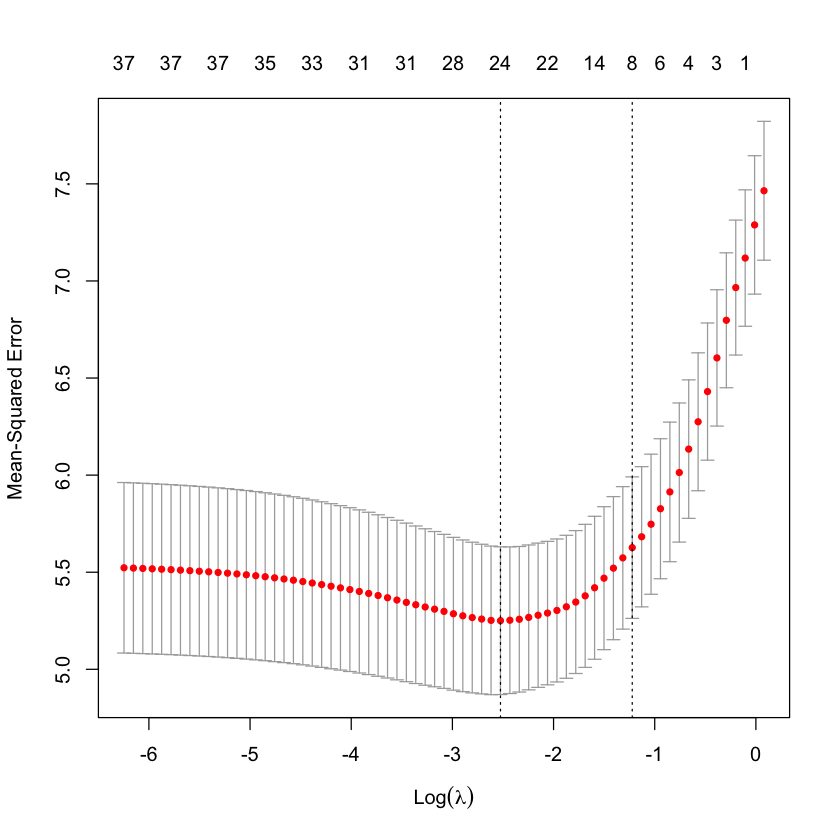

In [19]:
#NOT USED
# lets see the lambda values and
plot(cv_fit_1)

In [21]:
#NOT USED
# DATA 1 GLM Prediction:
prediction_glm_min_1 <- predict(cv_fit_1, data.matrix(select(data_test_1,-G1)), s='lambda.min')
prediction_glm_1se_1 <- predict(cv_fit_1, data.matrix(select(data_test_1,-G1)), s='lambda.1se')

In [23]:
# NOT USED
mse_glm_min_1 = mean(prediction_glm_min_1-data_test_1$G1) # 0.0268636788419662
mse_glm_1se_1 = mean(prediction_glm_1se_1-data_test_1$G1) # 0.0578184645948164

### DECISION TREE

In [54]:
# DATA 1 DECISION TREE
fit_control_1 = trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 10) 
# 
# we create our grid with 10 complexity parameters
# we do min # of instances at terminal node by hand because the tuneGrid of rpart does not support it.

grid_dt_1 <- expand.grid(cp = c(0.0001,0.0025,0.005,0.0075,0.01))
                        
dt_fit_1_10 <- train(G1 ~ .,
                 data = data_train_1,
                 method = "rpart", 
                 tuneGrid = grid_dt_1,
                 control = rpart.control(minbucket=c(10)),
                 trControl = fit_control_1)

In [35]:
dt_fit_1

CART 

488 samples
 41 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 440, 439, 439, 440, 439, 439, ... 
Resampling results across tuning parameters:

  cp      RMSE      Rsquared   MAE     
  0.0001  2.571887  0.1845622  2.017888
  0.0025  2.566274  0.1865807  2.014557
  0.0050  2.545146  0.1928768  1.989962
  0.0075  2.495949  0.2091302  1.943478
  0.0100  2.473776  0.2135289  1.929944

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.

In [36]:
dt_fit_1_50 <- train(G1 ~ .,
                 data = data_train_1,
                 method = "rpart", 
                 tuneGrid = grid_dt_1,
                 control = rpart.control(minbucket=c(50)),
                 trControl = fit_control_1)

In [37]:
dt_fit_1_50

CART 

488 samples
 41 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 439, 440, 439, 440, 440, 439, ... 
Resampling results across tuning parameters:

  cp      RMSE      Rsquared   MAE     
  0.0001  2.465277  0.1978229  1.936693
  0.0025  2.465277  0.1978229  1.936693
  0.0050  2.465277  0.1978229  1.936693
  0.0075  2.467516  0.1964974  1.936181
  0.0100  2.463003  0.1989082  1.930100

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.

In [38]:
dt_fit_1_100 <- train(G1 ~ .,
                 data = data_train_1,
                 method = "rpart", 
                 tuneGrid = grid_dt_1,
                 control = rpart.control(minbucket=c(100)),
                 trControl = fit_control_1)
dt_fit_1_100

CART 

488 samples
 41 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 439, 440, 442, 438, 438, 439, ... 
Resampling results across tuning parameters:

  cp      RMSE     Rsquared   MAE     
  0.0001  2.59709  0.1048233  2.036609
  0.0025  2.59709  0.1048233  2.036609
  0.0050  2.59709  0.1048233  2.036609
  0.0075  2.59709  0.1048233  2.036609
  0.0100  2.59709  0.1048233  2.036609

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.

In [40]:
dt_fit_1_70 <- train(G1 ~ .,
                 data = data_train_1,
                 method = "rpart", 
                 tuneGrid = grid_dt_1,
                 control = rpart.control(minbucket=c(70)),
                 trControl = fit_control_1)
dt_fit_1_70

CART 

488 samples
 41 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 438, 438, 439, 440, 440, 440, ... 
Resampling results across tuning parameters:

  cp      RMSE      Rsquared  MAE     
  0.0001  2.581039  0.12004   2.041651
  0.0025  2.581039  0.12004   2.041651
  0.0050  2.581039  0.12004   2.041651
  0.0075  2.581039  0.12004   2.041651
  0.0100  2.581039  0.12004   2.041651

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.

In [41]:
dt_fit_1_30 <- train(G1 ~ .,
                 data = data_train_1,
                 method = "rpart", 
                 tuneGrid = grid_dt_1,
                 control = rpart.control(minbucket=c(30)),
                 trControl = fit_control_1)
dt_fit_1_30

CART 

488 samples
 41 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 438, 440, 440, 439, 439, 440, ... 
Resampling results across tuning parameters:

  cp      RMSE      Rsquared   MAE     
  0.0001  2.458691  0.2045514  1.914524
  0.0025  2.458691  0.2045514  1.914524
  0.0050  2.458165  0.2048133  1.912528
  0.0075  2.459126  0.2042226  1.914656
  0.0100  2.455004  0.2054314  1.910981

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.

In [42]:
dt_fit_1_30 <- train(G1 ~ .,
                 data = data_train_1,
                 method = "rpart", 
                 tuneGrid = grid_dt_1,
                 control = rpart.control(minbucket=c(25)),
                 trControl = fit_control_1)
dt_fit_1_30

CART 

488 samples
 41 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 438, 441, 439, 439, 440, 438, ... 
Resampling results across tuning parameters:

  cp      RMSE      Rsquared   MAE     
  0.0001  2.458975  0.2143844  1.920710
  0.0025  2.458975  0.2143844  1.920710
  0.0050  2.461903  0.2125288  1.922666
  0.0075  2.458087  0.2140144  1.918363
  0.0100  2.446654  0.2166232  1.910755

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.

## 10 20 30 40 50 denedik 30 eniyisi dicem
bi de set seedi unutma

# Random forest

In [57]:
set.seed(1)
# choosing m=sqrt(# all features) or m=log_2(#all features) may be a good starting point
grid_rf_1=expand.grid(mtry = c(5, 7, 9, 13),
                    splitrule = c("variance","extratrees"),
                    min.node.size = c(5))

rf_fit_1 <- train(G1 ~ ., data = data_train_1,
                 method = "ranger", 
                 trControl = fit_control_1,
                 num.trees=500,
                 tuneGrid = grid_rf_1)
rf_fit_1

Random Forest 

488 samples
 41 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 390, 391, 390, 390, 391, 391, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE     
   5    variance    2.283561  0.3214414  1.769738
   5    extratrees  2.301224  0.3161572  1.791969
   7    variance    2.277637  0.3177189  1.765627
   7    extratrees  2.285543  0.3176786  1.780369
   9    variance    2.274926  0.3156715  1.763959
   9    extratrees  2.277815  0.3176698  1.774313
  13    variance    2.273213  0.3136214  1.766939
  13    extratrees  2.269137  0.3177609  1.768797

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 13, splitrule = extratrees
 and min.node.size = 5.

## This is also done lets mov eon to Gradient boosting

In [65]:
# Gradient Boosting
grid_gbm_1 <- expand.grid(interaction.depth = c(1, 3, 5, 6), 
                        n.trees = c(50,100,200), 
                        shrinkage = c(0.01,0.03,0.05), # cok instance varsa 10k+ falan 0.1 denenebilir
                        n.minobsinnode = 10)
gbm_fit_1 <- train(G1 ~ ., data = data_train_1,
                 method = "gbm", 
                 trControl = fit_control,
                 tuneGrid = grid_gbm_1
                  )
gbm_fit_1

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        7.1375             nan     0.0100    0.0226
     2        7.1155             nan     0.0100    0.0233
     3        7.0937             nan     0.0100    0.0239
     4        7.0705             nan     0.0100    0.0264
     5        7.0546             nan     0.0100    0.0243
     6        7.0326             nan     0.0100    0.0213
     7        7.0104             nan     0.0100    0.0212
     8        6.9926             nan     0.0100    0.0206
     9        6.9769             nan     0.0100    0.0131
    10        6.9620             nan     0.0100    0.0150
    20        6.7894             nan     0.0100    0.0109
    40        6.4764             nan     0.0100    0.0112
    60        6.2634             nan     0.0100    0.0098
    80        6.0762             nan     0.0100    0.0029
   100        5.9450             nan     0.0100    0.0000
   120        5.8248             nan     0.0100    0.0006
   140        

Stochastic Gradient Boosting 

488 samples
 41 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 391, 390, 389, 390, 392, 390, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  RMSE      Rsquared   MAE     
  0.01       1                   50      2.563788  0.2224970  2.050187
  0.01       1                  100      2.482987  0.2492925  1.964484
  0.01       1                  200      2.397866  0.2752410  1.869392
  0.01       3                   50      2.508944  0.2765462  1.989841
  0.01       3                  100      2.403566  0.2944718  1.878335
  0.01       3                  200      2.313419  0.3085434  1.789360
  0.01       5                   50      2.489253  0.2869587  1.968514
  0.01       5                  100      2.378115  0.3009191  1.855604
  0.01       5                  200      2.295939  0.3102068  1.771279
  0.01       6                   50      2.484285  

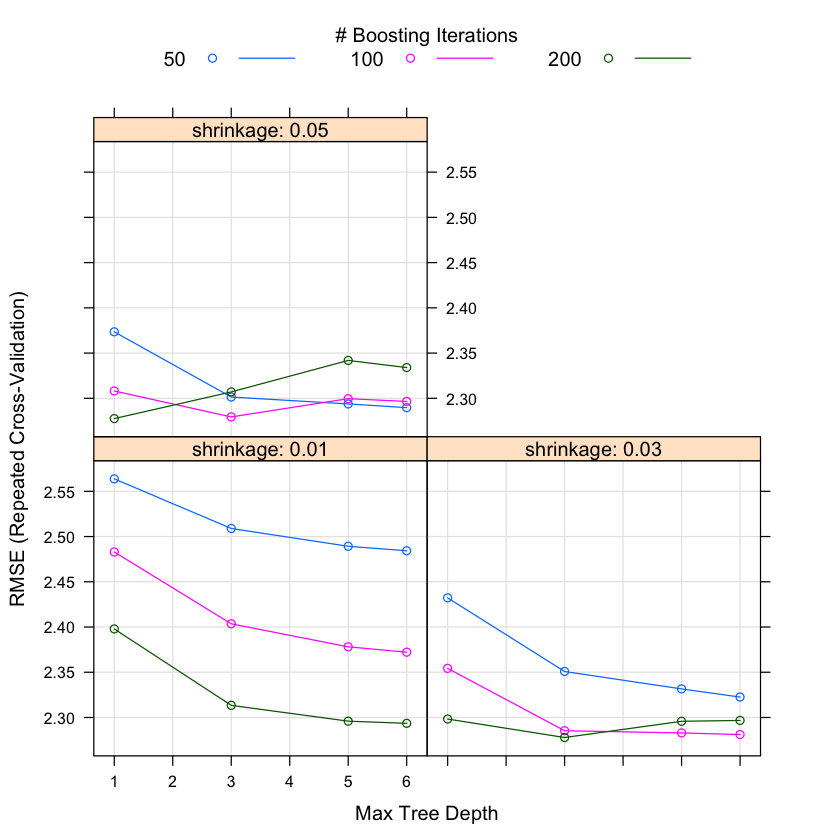

In [66]:
plot(gbm_fit_1)

#### should comment on that graph!

# NOTE THAT
we used only the training data for training and these ready functions gave us some 'success rates' but these rates are might be misleading so we'll be calculating the MSE with testing data using the methods with the "best" parameters. 


Note that the performance values we've seen were the results only from training data. Now we will test them on our test data

In [76]:
# create a function for calculating MSE
mse_calculate <- function(pred,real){
    return <- mean((pred-real)^2)
}

In [23]:
data.table(dt_fit_1_30$bestTune)
rf_fit_1$bestTune
gbm_fit_1$bestTune

ERROR: Error in data.table(dt_fit_1_30$bestTune): object 'dt_fit_1_30' not found


In [177]:
# Aga rewrite yaparken duzelir ins
bwplot(resamples(list(PRA=pra_fit_1_10, DT=dt_fit_1_30, RF=rf_fit_1, GBM= gbm_fit_1)))

ERROR: Error in Model %in% models: object 'Model' not found


In [170]:
# HATA ALIYoRUZ
first_comparison_1 <- list(pra=pra_fit_1_10, dt=dt_fit_1_30, rf=rf_fit_1, gbm=gbm_fit_1)
rezamplin <- resamples(first_comparison_1, metrics = 'MSRE')
bwplot(rezamplin)

ERROR: Error in Model %in% models: object 'Model' not found


In [111]:
pred_pra_1 <- predict(pra_fit_1_10, data_test_1)
pred_dt_1 <- predict(dt_fit_1_30, data_test_1)
pred_rf_1 <- predict(rf_fit_1, data_test_1)
pred_gbm_1 <- predict(gbm_fit_1, data_test_1)

In [112]:
mse_pra_1 <- mse_calculate(pred_pra_1, data_test_1$G1)
mse_dt_1 <- mse_calculate(pred_dt_1, data_test_1$G1)
mse_rf_1 <- mse_calculate(pred_rf_1, data_test_1$G1)
mse_gbm_1 <- mse_calculate(pred_gbm_1, data_test_1$G1)

MSE_1 <- data.frame(mse_pra_1,mse_dt_1,mse_rf_1,mse_gbm_1)
MSE_1

mse_pra_1,mse_dt_1,mse_rf_1,mse_gbm_1
<dbl>,<dbl>,<dbl>,<dbl>
5.728804,5.774891,5.250776,5.457103


In [169]:
pra_fit_1_10$results$RMSE
dt_fit_1_30$results$RMSE
rf_fit_1$results$RMSE
gbm_fit_1$results$RMSE

[1] 2.332360 2.311349 2.300166 2.296473 2.297801 2.301294 2.305903 2.311686
 [9] 2.318429 2.325673 2.333853 2.342699 2.351651 2.360483 2.369048 2.377651
[17] 2.386152 2.394696 2.403400 2.412446 2.421569 2.430869 2.440203 2.449683
[25] 2.459448 2.469472 2.479663 2.490044 2.500609 2.511391 2.522267 2.533336
[33] 2.544541 2.555757 2.566740 2.577394 2.587733 2.597509 2.606861 2.615692
[41] 2.624017 2.632067 2.639735 2.646990 2.654167 2.661304 2.668379 2.675547
[49] 2.682836 2.690201

[1] 2.458975 2.458975 2.461903 2.458087 2.446654

[1] 2.283561 2.301224 2.277637 2.285543 2.274926 2.277815 2.273213 2.269137

[1] 2.563788 2.432250 2.373499 2.508944 2.350849 2.301416 2.489253 2.331596
 [9] 2.293789 2.484285 2.322581 2.289695 2.482987 2.354288 2.308130 2.403566
[17] 2.285378 2.279432 2.378115 2.282929 2.299609 2.372182 2.281111 2.296539
[25] 2.397866 2.298307 2.277581 2.313419 2.277860 2.307058 2.295939 2.295788
[33] 2.341890 2.293525 2.296727 2.333979

## THE FINAL COMMENTS:

Is the cross-validation errorrate of different approaches consistent with the test error rate? b.What is your observation about the performance of the classifiers over all datasets?c.How would you compare training and test error? Is there any indication of underfitting or overfitting?

herhalde biraz overfit ettik? of yok ya

# SECOND DATASET

In [127]:
# Remove V1 i.e. ID
data_2 <- data_2  %>% select(-V1)
# DATA 1 splitting
set.seed(1)
# test-train index
index_2 <- createDataPartition(y = data_2$V2, p = .75, list = FALSE)
# create the split
data_train_2 <- data_2[index_2,]
data_test_2 <- data_2[-index_2,]

In [128]:
fit_control = trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 10) 

In [133]:
# TRUE GLM
grid_pra_2 <- expand.grid(lambda = c(seq(0.0003:0.004, by= 0.0003)), alpha=1)
                        
pra_fit_2 <- train(V2 ~ .,
                 data = data_train_2,
                 method = "glmnet", 
                 tuneGrid = grid_pra_2,
                 trControl = fit_control,
                  preProcess=c("center","scale"))

In [134]:
pra_fit_2

glmnet 

427 samples
 30 predictor
  2 classes: 'B', 'M' 

Pre-processing: centered (30), scaled (30) 
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 341, 341, 341, 342, 343, 341, ... 
Resampling results across tuning parameters:

  lambda  Accuracy   Kappa      
  0.0003  0.9751953  0.946893682
  0.0006  0.9756466  0.947750163
  0.0009  0.9765685  0.949764544
  0.0012  0.9746861  0.945715339
  0.0015  0.9739939  0.944227168
  0.0018  0.9746972  0.945738700
  0.0021  0.9746944  0.945694601
  0.0024  0.9739885  0.944181035
  0.0027  0.9744619  0.945143568
  0.0030  0.9746917  0.945653312
  0.0033  0.9744619  0.945130358
  0.0036  0.9742238  0.944608897
  0.0039  0.9737559  0.943571109
  0.0042  0.9735234  0.943037642
  0.0045  0.9725876  0.941032769
  0.0048  0.9725903  0.940985033
  0.0051  0.9725931  0.940970094
  0.0054  0.9728256  0.941446333
  0.0057  0.9723550  0.940418563
  0.0060  0.9716409  0.938816959
  0.0063  0.9716381  0.938793837
  0.0066

In [132]:
pra_fit_2

glmnet 

427 samples
 30 predictor
  2 classes: 'B', 'M' 

Pre-processing: centered (30), scaled (30) 
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 342, 342, 341, 341, 342, 342, ... 
Resampling results across tuning parameters:

  lambda  Accuracy   Kappa      
  0.003   0.9737805  0.943510117
  0.006   0.9716710  0.938754282
  0.009   0.9697859  0.934551095
  0.012   0.9700239  0.935039492
  0.015   0.9693207  0.933346703
  0.018   0.9686340  0.931800571
  0.021   0.9679309  0.930225389
  0.024   0.9662892  0.926564681
  0.027   0.9655862  0.924973506
  0.030   0.9648775  0.923353932
  0.033   0.9651101  0.923867678
  0.036   0.9639418  0.921276760
  0.039   0.9634767  0.920265570
  0.042   0.9634795  0.920244967
  0.045   0.9634795  0.920128241
  0.048   0.9616108  0.915822856
  0.051   0.9609022  0.914169827
  0.054   0.9583221  0.908282505
  0.057   0.9552824  0.901354400
  0.060   0.9545820  0.899808982
  0.063   0.9524780  0.894992261
  0.066 

# DT

In [154]:
# DATA 2 DECISION TREE

# we create our grid with 10 complexity parameters
# we do min # of instances at terminal node by hand because the tuneGrid of rpart does not support it.

grid_dt_2 <- expand.grid(cp = c(0.0001,0.001,0.005,0.01,0.05))
                        
dt_fit_2_10 <- train(V2 ~ .,
                 data = data_train_2,
                 method = "rpart", 
                 tuneGrid = grid_dt_2,
                 control = rpart.control(minbucket=c(10)),
                 trControl = fit_control)
dt_fit_2_10


CART 

427 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 343, 341, 342, 341, 341, 343, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  1e-04  0.9173296  0.8221196
  1e-03  0.9173296  0.8221196
  5e-03  0.9173296  0.8221196
  1e-02  0.9177974  0.8231057
  5e-02  0.9099125  0.8074991

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

In [155]:
                        
dt_fit_2_20 <- train(V2 ~ .,
                 data = data_train_2,
                 method = "rpart", 
                 tuneGrid = grid_dt_2,
                 control = rpart.control(minbucket=c(20)),
                 trControl = fit_control)
dt_fit_2_20


CART 

427 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 341, 342, 341, 343, 341, 341, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  1e-04  0.9141158  0.8180308
  1e-03  0.9141158  0.8180308
  5e-03  0.9141158  0.8180308
  1e-02  0.9141158  0.8187247
  5e-02  0.9054398  0.7976605

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

In [157]:
                        
dt_fit_2_30 <- train(V2 ~ .,
                 data = data_train_2,
                 method = "rpart", 
                 tuneGrid = grid_dt_2,
                 control = rpart.control(minbucket=c(30)),
                 trControl = fit_control)
dt_fit_2_30


CART 

427 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 341, 341, 343, 342, 341, 342, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  1e-04  0.8992903  0.7849301
  1e-03  0.8992903  0.7849301
  5e-03  0.8992903  0.7849301
  1e-02  0.8992903  0.7840908
  5e-02  0.8899305  0.7614151

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

In [158]:
                        
dt_fit_2_5 <- train(V2 ~ .,
                 data = data_train_2,
                 method = "rpart", 
                 tuneGrid = grid_dt_2,
                 control = rpart.control(minbucket=c(5)),
                 trControl = fit_control)
dt_fit_2_5


CART 

427 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 341, 342, 342, 341, 342, 342, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  1e-04  0.9322944  0.8539028
  1e-03  0.9322944  0.8539028
  5e-03  0.9329948  0.8553574
  1e-02  0.9360317  0.8623726
  5e-02  0.9182423  0.8250516

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.01.

##  RF

In [163]:
set.seed(1)
# choosing m=sqrt(# all features) or m=log_2(#all features) may be a good starting point = 5,5 or 5,9 this time
grid_rf_2=expand.grid(mtry = c(1,3,5,6,7,10),
                    splitrule = c("gini"),
                    min.node.size = c(5))

rf_fit_2 <- train(V2 ~ ., data = data_train_2,
                 method = "ranger", 
                 trControl = fit_control,
                 num.trees=500,
                 tuneGrid = grid_rf_2)
rf_fit_2

Random Forest 

427 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 342, 342, 341, 342, 341, 341, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   1    0.9581032  0.9092994
   3    0.9601797  0.9140538
   5    0.9585410  0.9105964
   6    0.9604124  0.9146496
   7    0.9594850  0.9126622
  10    0.9594822  0.9128061

Tuning parameter 'splitrule' was held constant at a value of gini

Tuning parameter 'min.node.size' was held constant at a value of 5
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 6, splitrule = gini
 and min.node.size = 5.

# GBM 

In [164]:
# Gradient Boosting
grid_gbm_2 <- expand.grid(interaction.depth = c(1, 3, 5, 6), 
                        n.trees = c(50,100,200), 
                        shrinkage = c(0.01,0.03,0.05), # cok instance varsa 10k+ falan 0.1 denenebilir
                        n.minobsinnode = 10)
gbm_fit_2 <- train(V2 ~ ., data = data_train_2,
                 method = "gbm", 
                 trControl = fit_control,
                 tuneGrid = grid_gbm_2
                  )
gbm_fit_2

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3056             nan     0.0100    0.0066
     2        1.2917             nan     0.0100    0.0062
     3        1.2778             nan     0.0100    0.0059
     4        1.2635             nan     0.0100    0.0069
     5        1.2489             nan     0.0100    0.0065
     6        1.2351             nan     0.0100    0.0065
     7        1.2219             nan     0.0100    0.0061
     8        1.2090             nan     0.0100    0.0061
     9        1.1961             nan     0.0100    0.0057
    10        1.1842             nan     0.0100    0.0055
    20        1.0723             nan     0.0100    0.0046
    40        0.8952             nan     0.0100    0.0035
    60        0.7629             nan     0.0100    0.0024
    80        0.6608             nan     0.0100    0.0021
   100        0.5802             nan     0.0100    0.0017
   120        0.5153             nan     0.0100    0.0014
   140        

Stochastic Gradient Boosting 

427 samples
 30 predictor
  2 classes: 'B', 'M' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 341, 342, 341, 343, 341, 341, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.01       1                   50      0.9074716  0.7919678
  0.01       1                  100      0.9219808  0.8283180
  0.01       1                  200      0.9306544  0.8493373
  0.01       3                   50      0.9294807  0.8441711
  0.01       3                  100      0.9393139  0.8680445
  0.01       3                  200      0.9491554  0.8901832
  0.01       5                   50      0.9306598  0.8470001
  0.01       5                  100      0.9409362  0.8717225
  0.01       5                  200      0.9507779  0.8938688
  0.01       6                   50      0.9313354  0.8484697
  0.01       6                  100      0.9416506  0.87

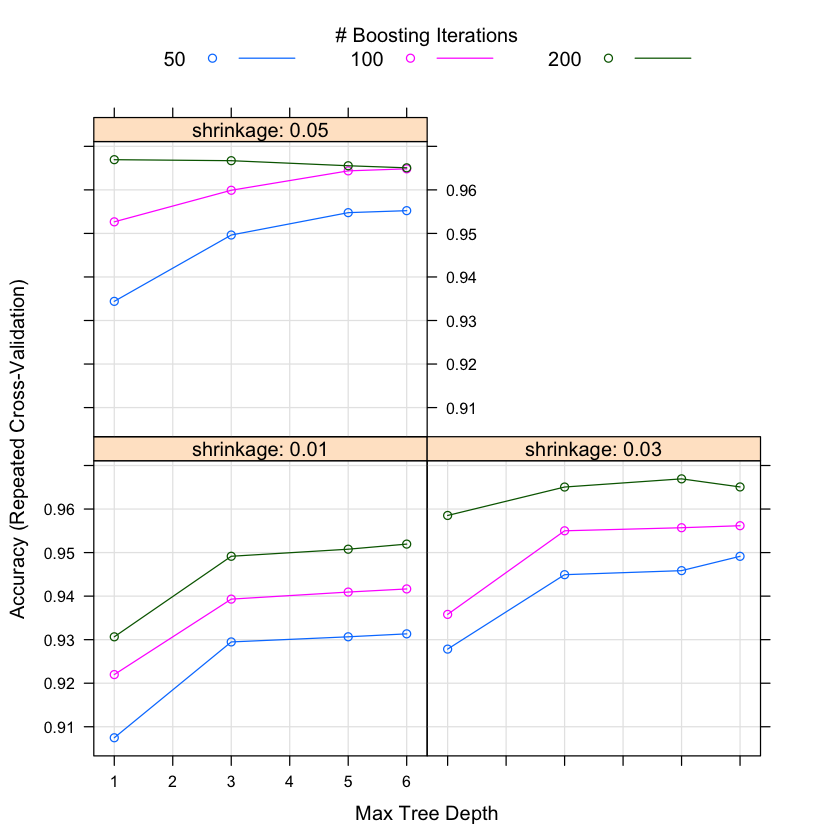

In [165]:
plot(gbm_fit_2)

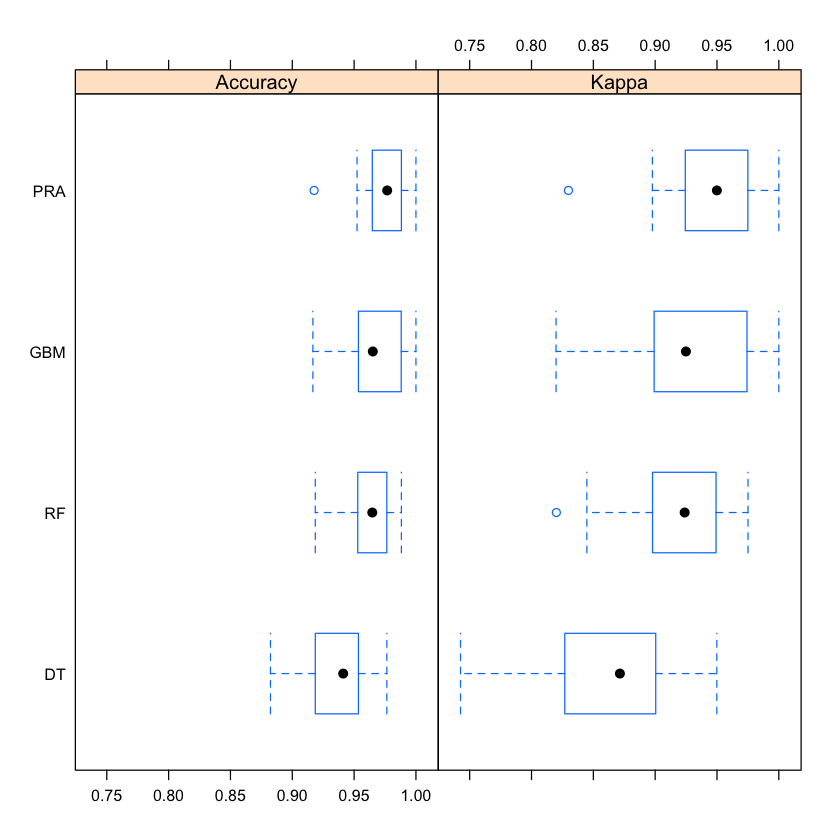

In [168]:
bwplot(resamples(list(PRA=pra_fit_2, DT=dt_fit_2_5, RF=rf_fit_2, GBM= gbm_fit_2)))

## Test Data 

In [200]:
results <- cbind(pred_pra_2,pred_dt_2,pred_rf_2,pred_gbm_2,ifelse(data_test_2$V2=='M',2,1))

In [206]:
nrow(data_test_2[data_test_2$V2==pred_pra_2,])

[1] 138

In [ ]:
a  %>% filter(pred_pra_2!=data_test_2$V2)

In [208]:
accuracy_calculate <- function(pred,real){
    return(nrow(real[real$V2==pred,])/nrow(real))
}

In [195]:
pred_pra_2 <- predict(pra_fit_2, data_test_2)
pred_dt_2 <- predict(dt_fit_2_5, data_test_2)
pred_rf_2 <- predict(rf_fit_2, data_test_2)
pred_gbm_2 <- predict(gbm_fit_2, data_test_2)



In [210]:
accuracy_pra_2 <- accuracy_calculate(pred_pra_2,data_test_2)
accuracy_dt_2 <- accuracy_calculate(pred_dt_2,data_test_2)
accuracy_rf_2 <- accuracy_calculate(pred_rf_2,data_test_2)
accuracy_gbm_2 <- accuracy_calculate(pred_gbm_2,data_test_2)

accuracy_results_2 <- data.frame(accuracy_pra_2,accuracy_dt_2,accuracy_rf_2,accuracy_gbm_2)

In [211]:
accuracy_results_2

accuracy_pra_2,accuracy_dt_2,accuracy_rf_2,accuracy_gbm_2
<dbl>,<dbl>,<dbl>,<dbl>
0.971831,0.9577465,0.9507042,0.971831


# DATA 3 

In [6]:
# Online News Popularity (predicts the total number of shares the news will get) [39k instances]
# DATA 3 splitting 
set.seed(1)
# test-train index
index_3 <- createDataPartition(y = data_3$shares, p = .75, list = FALSE)
# create the split
data_train_3 <- data_3[index_3,]
data_test_3 <- data_3[-index_3,]

In [8]:
fit_control_3 <- trainControl(method = "cv",
                              number = 10)

In [10]:
set.seed(1)
# GLM
grid_pra_3 <- expand.grid(lambda = c(0.01,0.05,0.1,0.5), alpha=1)
                        
pra_fit_3 <- train(shares ~ .,
                 data = data_train_3,
                 method = "glmnet", 
                 tuneGrid = grid_pra_3,
                 trControl = fit_control_3)

In [11]:
pra_fit_3

glmnet 

29734 samples
   58 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 26762, 26761, 26761, 26759, 26760, 26760, ... 
Resampling results across tuning parameters:

  lambda  RMSE      Rsquared    MAE     
  0.01    10761.08  0.02505472  3039.970
  0.05    10761.08  0.02505472  3039.970
  0.10    10761.08  0.02505472  3039.970
  0.50    10760.76  0.02508120  3039.102

Tuning parameter 'alpha' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.5.

In [12]:
# DATA 3 DECISION TREE
set.seed(1)
# we create our grid with 10 complexity parameters
# we do min # of instances at terminal node by hand because the tuneGrid of rpart does not support it.

grid_dt_3 <- expand.grid(cp = c(0.0001,0.001,0.005,0.01,0.05))
                        
dt_fit_3_100 <- train(shares ~ .,
                 data = data_train_3,
                 method = "rpart", 
                 tuneGrid = grid_dt_3,
                 control = rpart.control(minbucket=c(100)),
                 trControl = fit_control_3)
dt_fit_3_100


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


CART 

29734 samples
   58 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 26762, 26760, 26761, 26760, 26763, 26760, ... 
Resampling results across tuning parameters:

  cp     RMSE      Rsquared     MAE     
  1e-04  10536.60  0.020245668  3093.646
  1e-03  10514.85  0.018028063  3081.986
  5e-03  10487.32  0.014698921  3094.789
  1e-02  10533.00  0.005148582  3150.557
  5e-02  10545.51          NaN  3170.075

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.005.

In [8]:
# # DATA 3 DECISION TREE

# # we create our grid with 10 complexity parameters
# # we do min # of instances at terminal node by hand because the tuneGrid of rpart does not support it.

# grid_dt_3 <- expand.grid(cp = c(0.0001,0.001,0.005,0.01,0.05))
                        
# dt_fit_3_100 <- train(shares ~ .,
#                  data = data_train_3,
#                  method = "rpart", 
#                  tuneGrid = grid_dt_3,
#                  control = rpart.control(minbucket=c(100)),
#                  trControl = fit_control_3)
# dt_fit_3_100


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


CART 

29734 samples
   58 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 23787, 23787, 23787, 23787, 23788, 23787, ... 
Resampling results across tuning parameters:

  cp     RMSE      Rsquared     MAE     
  1e-04  11213.79  0.014845837  3095.383
  1e-03  11199.29  0.012823043  3087.999
  5e-03  11185.41  0.008870075  3107.298
  1e-02  11200.70  0.006606671  3130.997
  5e-02  11222.81          NaN  3170.044

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.005.

In [14]:
dt_fit_3_50 <- train(shares ~ .,
                 data = data_train_3,
                 method = "rpart", 
                 tuneGrid = grid_dt_3,
                 control = rpart.control(minbucket=c(50)),
                 trControl = fit_control_3)
dt_fit_3_50

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


CART 

29734 samples
   58 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 26761, 26760, 26760, 26761, 26761, 26760, ... 
Resampling results across tuning parameters:

  cp     RMSE      Rsquared     MAE     
  1e-04  11210.19  0.013689308  3131.519
  1e-03  11178.48  0.011110737  3096.624
  5e-03  11125.71  0.009339603  3099.498
  1e-02  11128.46  0.007278049  3128.016
  5e-02  11152.06          NaN  3170.031

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.005.

In [13]:
dt_fit_3_300 <- train(shares ~ .,
                 data = data_train_3,
                 method = "rpart", 
                 tuneGrid = grid_dt_3,
                 control = rpart.control(minbucket=c(300)),
                 trControl = fit_control_3)
dt_fit_3_300

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


CART 

29734 samples
   58 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 26761, 26761, 26762, 26760, 26759, 26761, ... 
Resampling results across tuning parameters:

  cp     RMSE      Rsquared     MAE     
  1e-04  10586.51  0.022618856  3072.392
  1e-03  10592.50  0.019994950  3079.352
  5e-03  10598.53  0.015155040  3092.125
  1e-02  10651.84  0.004187415  3147.223
  5e-02  10661.14          NaN  3170.047

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 1e-04.

## Random Forest

In [16]:
set.seed(1)
# choosing m=sqrt(# all features) or m=log_2(#all features) may be a good starting point = 6 or 8 this time
grid_rf_3=expand.grid(mtry = c(6,7,8),
                    splitrule = c("variance"),
                    min.node.size = c(5))

rf_fit_3 <- train(shares ~ ., data = data_train_3,
                 method = "ranger",
                 trControl = fit_control,
                 num.trees= 500,
                 tuneGrid = grid_rf_3)
rf_fit_3

Growing trees.. Progress: 81%. Estimated remaining time: 7 seconds.


Warning message:
“model fit failed for Fold1.Rep01: mtry=7, splitrule=variance, min.node.size=5 Error in ranger::ranger(dependent.variable.name = ".outcome", data = x,  : 
  User interrupt or internal error.
”


Growing trees.. Progress: 43%. Estimated remaining time: 40 seconds.
Growing trees.. Progress: 72%. Estimated remaining time: 24 seconds.
Growing trees.. Progress: 28%. Estimated remaining time: 1 minute, 20 seconds.
Growing trees.. Progress: 52%. Estimated remaining time: 56 seconds.
Growing trees.. Progress: 80%. Estimated remaining time: 23 seconds.
Growing trees.. Progress: 30%. Estimated remaining time: 1 minute, 13 seconds.
Growing trees.. Progress: 76%. Estimated remaining time: 19 seconds.
Growing trees.. Progress: 39%. Estimated remaining time: 47 seconds.
Growing trees.. Progress: 79%. Estimated remaining time: 16 seconds.
Growing trees.. Progress: 55%. Estimated remaining time: 25 seconds.
Growing trees.. Progress: 48%. Estimated remaining time: 33 seconds.
Growing trees.. Progress: 97%. Estimated remaining time: 2 seconds.
Growing trees.. Progress: 44%. Estimated remaining time: 39 seconds.
Growing trees.. Progress: 93%. Estimated remaining time: 2 seconds.
Growing trees.. 

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Growing trees.. Progress: 34%. Estimated remaining time: 1 minute, 0 seconds.
Growing trees.. Progress: 56%. Estimated remaining time: 48 seconds.
Growing trees.. Progress: 79%. Estimated remaining time: 25 seconds.


Random Forest 

29734 samples
   58 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 23787, 23788, 23788, 23787, 23786, 23787, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared    MAE     
  6     11202.75  0.02156976  3211.823
  7     11208.29  0.02090939  3223.416
  8     11234.37  0.02111672  3236.733

Tuning parameter 'splitrule' was held constant at a value of variance

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 6, splitrule = variance
 and min.node.size = 5.

### GBM

In [15]:
# Gradient Boosting
set.seed(1)
grid_gbm_3 <- expand.grid(interaction.depth = c(1, 3, 6), 
                        n.trees = c(50,100,150), 
                        shrinkage = c(0.2,0.1,0.05), # cok instance varsa 10k+ falan 0.1 denenebilir
                        n.minobsinnode = 10)
gbm_fit_3 <- train(shares ~ ., data = data_train_3,
                 method = "gbm", 
                 trControl = fit_control_3,
                 tuneGrid = grid_gbm_3
                  )
gbm_fit_3

# DATA 4

In [6]:
custom_func <- function(x) {
  return (ifelse(x=='?',NA,as.numeric(x)))
}
#turn elements from char to doubles and ? to NA
data_4 <- suppressWarnings(apply(data_4,2,custom_func))
# replace NA with mean of that column
suppressWarnings(for(i in 1:ncol(data_4)){
  data_4[is.na(data_4[,i]), i] <- mean(data_4[,i], na.rm = TRUE)
})
data_4

id,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,⋯,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
1,0.1592900,0.46240,0.077730,1.16830,-44.8530,0.46702000,0.1894800,0.828950,1.12230,⋯,0.1089900,0.415570,0.89101,0.0014220,7.7928,4.9914,119.810,3.0465,3.05600,0
2,-0.1274300,0.46243,0.269170,1.75170,7.5970,0.00092515,-0.1274300,1.162500,1.29440,⋯,-0.0893720,-0.237040,1.06250,0.1504100,5.4327,3.4629,100.970,3.6150,3.47250,0
3,0.0704880,0.23570,0.527810,3.23930,125.6800,0.16367000,0.0868950,2.871800,1.05740,⋯,0.0542860,0.104130,0.94571,0.0000000,7.1070,3.3808,76.076,4.7978,4.78180,0
4,0.1367600,0.40538,0.315430,1.87050,19.1150,0.50497000,0.1367600,1.453900,1.11440,⋯,0.1026300,0.232030,0.89737,0.0730240,6.1384,4.2241,88.299,4.1337,4.64840,0
5,-0.1100800,0.69793,0.188780,1.27130,-15.3440,0.00000000,-0.1100800,0.432820,1.73500,⋯,0.4398800,-0.364400,0.57153,0.0000000,18.8010,2.7925,146.390,2.4934,15.03600,0
6,0.0215390,0.58425,0.086614,1.17910,-36.3940,-0.00160870,0.0296280,0.711610,1.43880,⋯,0.2196000,0.051807,0.80128,0.1250800,8.7603,3.8576,122.700,2.9746,3.34820,0
7,0.2274300,0.52266,0.444560,1.87000,-8.6787,0.00000000,0.2830000,0.913280,1.98110,⋯,0.1611000,0.476460,0.85765,0.0245110,4.1654,5.2485,94.141,3.8772,44.53900,0
8,0.0386620,0.59498,0.070504,1.11910,-37.6400,-0.52978000,0.0386620,0.680740,3.08610,⋯,0.2705900,0.095456,0.72991,0.0000000,11.0850,8.4593,70.003,5.2141,9.14080,0
9,0.1310300,0.47202,0.493500,2.13740,31.8760,0.37472000,0.1637800,1.118500,1.07290,⋯,0.0679520,0.248170,0.93205,0.0722130,7.5119,4.4377,69.488,5.2527,31.39200,0
10,0.1769800,0.19359,0.139250,3.77790,124.1000,0.33845000,0.2128100,4.165600,1.21280,⋯,0.1754700,0.219460,0.82453,0.1779000,9.2352,2.4957,51.133,7.1382,0.44144,0


In [7]:
data_4 <- select(data.frame(data_4),-id)
data_4

Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,⋯,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1592900,0.46240,0.077730,1.16830,-44.8530,0.46702000,0.1894800,0.828950,1.12230,0.383300,⋯,0.1089900,0.415570,0.89101,0.0014220,7.7928,4.9914,119.810,3.0465,3.05600,0
-0.1274300,0.46243,0.269170,1.75170,7.5970,0.00092515,-0.1274300,1.162500,1.29440,0.537570,⋯,-0.0893720,-0.237040,1.06250,0.1504100,5.4327,3.4629,100.970,3.6150,3.47250,0
0.0704880,0.23570,0.527810,3.23930,125.6800,0.16367000,0.0868950,2.871800,1.05740,0.676890,⋯,0.0542860,0.104130,0.94571,0.0000000,7.1070,3.3808,76.076,4.7978,4.78180,0
0.1367600,0.40538,0.315430,1.87050,19.1150,0.50497000,0.1367600,1.453900,1.11440,0.589380,⋯,0.1026300,0.232030,0.89737,0.0730240,6.1384,4.2241,88.299,4.1337,4.64840,0
-0.1100800,0.69793,0.188780,1.27130,-15.3440,0.00000000,-0.1100800,0.432820,1.73500,0.302070,⋯,0.4398800,-0.364400,0.57153,0.0000000,18.8010,2.7925,146.390,2.4934,15.03600,0
0.0215390,0.58425,0.086614,1.17910,-36.3940,-0.00160870,0.0296280,0.711610,1.43880,0.415750,⋯,0.2196000,0.051807,0.80128,0.1250800,8.7603,3.8576,122.700,2.9746,3.34820,0
0.2274300,0.52266,0.444560,1.87000,-8.6787,0.00000000,0.2830000,0.913280,1.98110,0.477340,⋯,0.1611000,0.476460,0.85765,0.0245110,4.1654,5.2485,94.141,3.8772,44.53900,0
0.0386620,0.59498,0.070504,1.11910,-37.6400,-0.52978000,0.0386620,0.680740,3.08610,0.405020,⋯,0.2705900,0.095456,0.72991,0.0000000,11.0850,8.4593,70.003,5.2141,9.14080,0
0.1310300,0.47202,0.493500,2.13740,31.8760,0.37472000,0.1637800,1.118500,1.07290,0.527980,⋯,0.0679520,0.248170,0.93205,0.0722130,7.5119,4.4377,69.488,5.2527,31.39200,0


In [8]:
data_4$class <- as.factor(data_4$class)
data_4

Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,⋯,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.1592900,0.46240,0.077730,1.16830,-44.8530,0.46702000,0.1894800,0.828950,1.12230,0.383300,⋯,0.1089900,0.415570,0.89101,0.0014220,7.7928,4.9914,119.810,3.0465,3.05600,0
-0.1274300,0.46243,0.269170,1.75170,7.5970,0.00092515,-0.1274300,1.162500,1.29440,0.537570,⋯,-0.0893720,-0.237040,1.06250,0.1504100,5.4327,3.4629,100.970,3.6150,3.47250,0
0.0704880,0.23570,0.527810,3.23930,125.6800,0.16367000,0.0868950,2.871800,1.05740,0.676890,⋯,0.0542860,0.104130,0.94571,0.0000000,7.1070,3.3808,76.076,4.7978,4.78180,0
0.1367600,0.40538,0.315430,1.87050,19.1150,0.50497000,0.1367600,1.453900,1.11440,0.589380,⋯,0.1026300,0.232030,0.89737,0.0730240,6.1384,4.2241,88.299,4.1337,4.64840,0
-0.1100800,0.69793,0.188780,1.27130,-15.3440,0.00000000,-0.1100800,0.432820,1.73500,0.302070,⋯,0.4398800,-0.364400,0.57153,0.0000000,18.8010,2.7925,146.390,2.4934,15.03600,0
0.0215390,0.58425,0.086614,1.17910,-36.3940,-0.00160870,0.0296280,0.711610,1.43880,0.415750,⋯,0.2196000,0.051807,0.80128,0.1250800,8.7603,3.8576,122.700,2.9746,3.34820,0
0.2274300,0.52266,0.444560,1.87000,-8.6787,0.00000000,0.2830000,0.913280,1.98110,0.477340,⋯,0.1611000,0.476460,0.85765,0.0245110,4.1654,5.2485,94.141,3.8772,44.53900,0
0.0386620,0.59498,0.070504,1.11910,-37.6400,-0.52978000,0.0386620,0.680740,3.08610,0.405020,⋯,0.2705900,0.095456,0.72991,0.0000000,11.0850,8.4593,70.003,5.2141,9.14080,0
0.1310300,0.47202,0.493500,2.13740,31.8760,0.37472000,0.1637800,1.118500,1.07290,0.527980,⋯,0.0679520,0.248170,0.93205,0.0722130,7.5119,4.4377,69.488,5.2527,31.39200,0


In [7]:
# set.seed(1)
# # test-train index
# index_4 <- createDataPartition(y = data_4$class, p = .75, list = FALSE)
# # create the split
# im_data_train_4 <- data_4[index_4,]
# data_test_4 <- data_4[-index_4,]

In [8]:
# im_data_train_4$class <- as.factor(im_data_train_4$class)

In [11]:
fit_control_4 = trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 1) 

In [ ]:
# # showing that without solving class imbalance we get worse results (only with GLM)
# set.seed(1)
# # grid_pra_4 <- expand.grid(lambda = c(0.001,0.01,0.05,0.1), alpha=1)
# grid_pra_4 <- expand.grid(lambda = 0.1, alpha=1)

# pra_fit_4 <- train(class ~ .,
#                  data = im_data_train_4,
#                  method = "glmnet", 
#                  tuneGrid = grid_pra_4,
#                  trControl = fit_control_4)

In [9]:
set.seed(1)
# test-train index
index_4 <- createDataPartition(y = data_4$class, p = .75, list = FALSE)
# create the split
im_data_train_4 <- data_4[index_4,]
data_test_4 <- data_4[-index_4,]

In [10]:
#DOWN SAMPLING
data_train_4 <- downSample(select(im_data_train_4,-class), im_data_train_4$class, list = FALSE, yname='class')
summary(data_train_4$class) 

0   1 
387 387

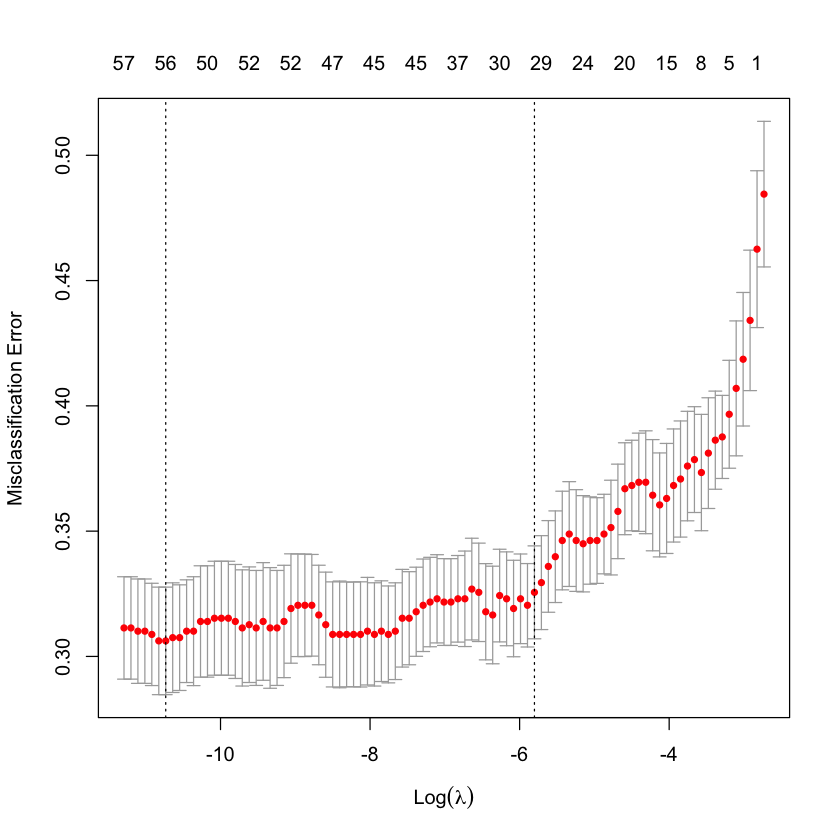

In [11]:
set.seed(1)
cvfit4 = cv.glmnet(data.matrix(select(data_train_4,-class)), data_train_4$class, family='binomial', nfolds=10, type.measure='class')
plot(cvfit4)

In [14]:
# GLM with downsampling
set.seed(1)
grid_pra_4 <- expand.grid(lambda = c(0.001,0.00001,0.000001), alpha=1)
# grid_pra_4 <- expand.grid(lambda = 0.1, alpha=1)

pra_fit_4 <- train(class ~ .,
                 data = data_train_4,
                 method = "glmnet", 
                 tuneGrid = grid_pra_4,
                 trControl = fit_control_4)



Warning message:
“from glmnet Fortran code (error code -91); Convergence for 91th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


In [16]:
pra_fit_4

glmnet 

774 samples
 64 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 697, 696, 696, 697, 697, 697, ... 
Resampling results across tuning parameters:

  lambda  Accuracy   Kappa    
  1e-06   0.6861209  0.3721626
  1e-05   0.6861209  0.3721626
  1e-04   0.6835231  0.3670284
  1e-03   0.6784623  0.3570031

Tuning parameter 'alpha' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 1e-05.

In [15]:
pra_fit_4

glmnet 

774 samples
 64 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 10 times) 
Summary of sample sizes: 619, 619, 620, 619, 619, 619, ... 
Resampling results across tuning parameters:

  lambda  Accuracy   Kappa    
  0.001   0.6873316  0.3746718
  0.010   0.6449450  0.2899027
  0.050   0.6348770  0.2699479
  0.100   0.5719455  0.1456562

Tuning parameter 'alpha' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 1 and lambda = 0.001.

In [22]:
# pra_fit_4 # az olan

glmnet 

774 samples
 65 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 619, 619, 620, 619, 619 
Resampling results:

  Accuracy   Kappa    
  0.9082949  0.8165329

Tuning parameter 'alpha' was held constant at a value of 1
Tuning
 parameter 'lambda' was held constant at a value of 0.1

## DT

In [30]:
data_train_4

id,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,⋯,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
3022,0.042797,0.32697,-0.057101,0.82374,-67.659,0.055212,0.054558,1.9507,1.16680,⋯,0.14299,0.0671,0.85701,0.0047091,?,2.2297,230.01,1.5869,0.70121,0
7824,-0.074541,0.16555,0.36286,3.1918,18.275,-0.20739,-0.072467,4.2935,0.94115,⋯,-0.06253,-0.10487,1.0625,0,3.7586,5.6805,53.139,6.8688,2.4113,0
7945,0.1314,0.38915,0.11472,1.4392,-32.988,0.5594,0.1314,1.4458,1.12850,⋯,0.11388,0.23354,0.88612,0.22741,6.2359,24.184,73.508,4.9654,2.0783,0
7534,0.10573,0.069709,0.73035,11.477,2436.3,0,0.10573,13.345,0.23289,⋯,-0.59501,0.11365,1.6205,0,?,0.49768,109.25,3.3408,1.1648,0
7651,0.00087426,0.53962,-0.041558,0.91007,652.57,0,0.00087426,0.85316,2.84860,⋯,-0.0094996,0.001899,1.017,0.0049614,29.517,9.9405,59.215,6.164,4.9163,0
2296,0.17781,0.21705,0.40027,2.8441,72.775,0.34346,0.221,3.5651,1.16700,⋯,0.14312,0.22978,0.85688,0,11.914,4.1406,49.58,7.3618,4.1756,0
6640,-0.11966,0.81797,-0.1087,0.8668,-39.192,-0.14729,-0.11787,0.19788,0.98351,⋯,-0.01677,-0.73929,1.0168,0.011767,13.311,7.0475,91.966,3.9688,11.068,0
5416,0.072634,0.3554,0.58928,2.6871,130.35,0,0.1116,1.8137,1.07840,⋯,0.10835,0.11268,0.90261,0.0086129,16.461,2.908,118.22,3.0875,17.551,0
7896,0.14707,0.25299,0.69602,3.7511,131.86,0.21548,0.18342,2.1033,1.13450,⋯,0.11853,0.27638,0.88147,0,13.734,4.4617,52.473,6.956,34.519,0


In [21]:
# DATA 4 DECISION TREE

# we create our grid with 10 complexity parameters
# we do min # of instances at terminal node by hand because the tuneGrid of rpart does not support it.

grid_dt_4 <- expand.grid(cp = c(0.0001,0.001,0.01,0.05))
                        
dt_fit_3_10 <- train(class ~ .,
                 data = data_train_4,
                 method = "rpart", 
                 tuneGrid = grid_dt_4,
                 control = rpart.control(minbucket=c(10)),
                 trControl = trainControl(method = "cv"))
dt_fit_3_10


CART 

774 samples
 64 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 696, 696, 697, 696, 696, 696, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  1e-04  0.7091553  0.4180823
  1e-03  0.7117527  0.4232218
  1e-02  0.7145179  0.4290358
  5e-02  0.7183970  0.4369704

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.05.

In [17]:
                        
dt_fit_3_50 <- train(class ~ .,
                 data = data_train_4,
                 method = "rpart", 
                 tuneGrid = grid_dt_4,
                 control = rpart.control(minbucket=c(50)),
                 trControl = trainControl(method = "cv"))
dt_fit_3_50

CART 

774 samples
 64 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 696, 698, 697, 697, 696, 696, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.001  0.7351929  0.4704842
  0.005  0.7313467  0.4627919
  0.010  0.7313467  0.4627919
  0.050  0.7106670  0.4209381

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.001.

In [18]:
                        
dt_fit_3_100 <- train(class ~ .,
                 data = data_train_4,
                 method = "rpart", 
                 tuneGrid = grid_dt_4,
                 control = rpart.control(minbucket=c(100)),
                 trControl = trainControl(method = "cv"))
dt_fit_3_100

CART 

774 samples
 64 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 696, 697, 696, 697, 697, 696, ... 
Resampling results across tuning parameters:

  cp     Accuracy   Kappa    
  0.001  0.6795415  0.3590625
  0.005  0.6795415  0.3590625
  0.010  0.6652558  0.3304689
  0.050  0.6755455  0.3510414

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.005.